In [1]:
'''
This module check the data for inconsistencies and processes the data so that it can be suitable
for further analysis.
1. Data Exploration
    a. Checking Distribution of the given features
    b. Checking for Outliers
    c. Checking distribution of response variable with respect to dependent variables
2. Data Imputation
    a. Identify inconsistencies
    b. Imputation of NaN values in 'No_of_victims' columns
    c. Imputation of missing values for 'Location_types'

'''

"\nThis module check the data for inconsistencies and processes the data so that it can be suitable\nfor further analysis.\n1. Data Imputation\n    a. Identify inconsistencies\n    b. Imputation of NaN values in 'No_of_victims' columns\n    c. Imputation of missing values for 'Location_types'\n\n"

# 1. Data Exploration

## 1.a Checking Distribution of the given features

In [18]:
#### Importing Libraries and Modules
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [42]:
#### Importing data and viewing a snapshot
train = pd.read_csv('../data/train.csv')
train.head()

,incident_datetime,incident_cord_x,incident_cord_y,num_victims,location_type,Crime_Type
0,06-Jun-2044 01:54:00,26.622589,-38.446780,1.0,0,LARCENY-FROM VEHICLE
1,10-Jun-2044 13:00:00,26.619337,-38.441202,1.0,13,LARCENY-NON VEHICLE
2,25-Feb-2044 09:00:00,26.616737,-38.444000,1.0,4,LARCENY-NON VEHICLE
3,02-Jun-2044 09:30:00,26.620286,-38.444994,1.0,33,LARCENY-NON VEHICLE
4,16-Mar-2044 19:20:00,26.626383,-38.443595,1.0,15,AUTO THEFT


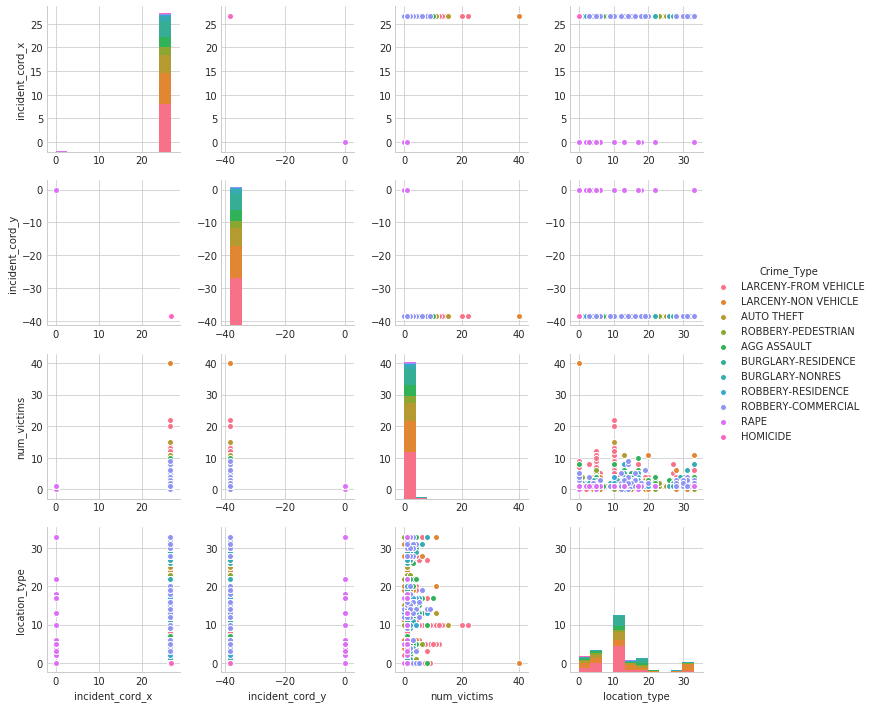

In [19]:
## Plotting the variables 
# colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette("husl")
sns.pairplot(train, hue="Crime_Type")

## 1.b Checking Distribution for Outliers

In [20]:
## looks like num victims has some outliers
train[(np.abs(train['num_victims']-train['num_victims'].mean())>(4*train['num_victims'].std()))].shape

(307, 6)

##### Around 307 values for No of victims are outside 4 standard deviations from the mean.


In [23]:
## Lot of incidents have 0 coordinates
print (train[train['incident_cord_x']==0].shape)
train[train['incident_cord_x']==0]['Crime_Type'].value_counts()

(133, 6)


RAPE    133
Name: Crime_Type, dtype: int64

##### There are around 133 data points with 0 coordinates and all of them belong to the category of Rape. If we can assign this to a cluster, our model can straightaway
##### identify the crime from this


## 1.c Checking distribution of response variable with respect to dependent variables

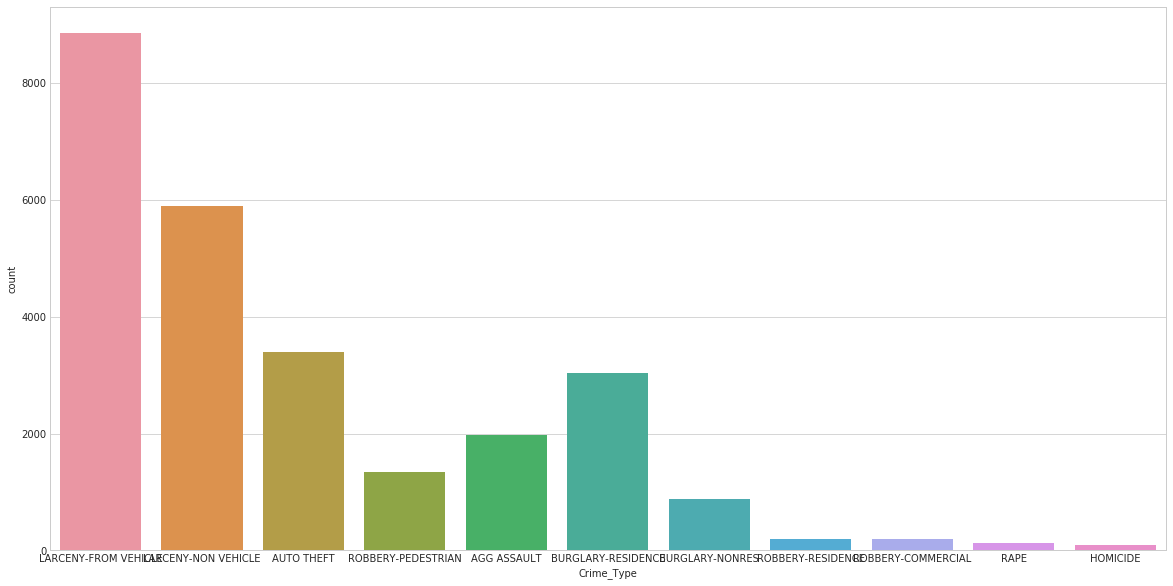

In [33]:
# Setting size
plt.subplots(figsize=(20,10))
'''
Plotting frequency crimes by Type
'''

sns.countplot(train['Crime_Type'])


#### Majority of the crimes are coming from the top 4 categories


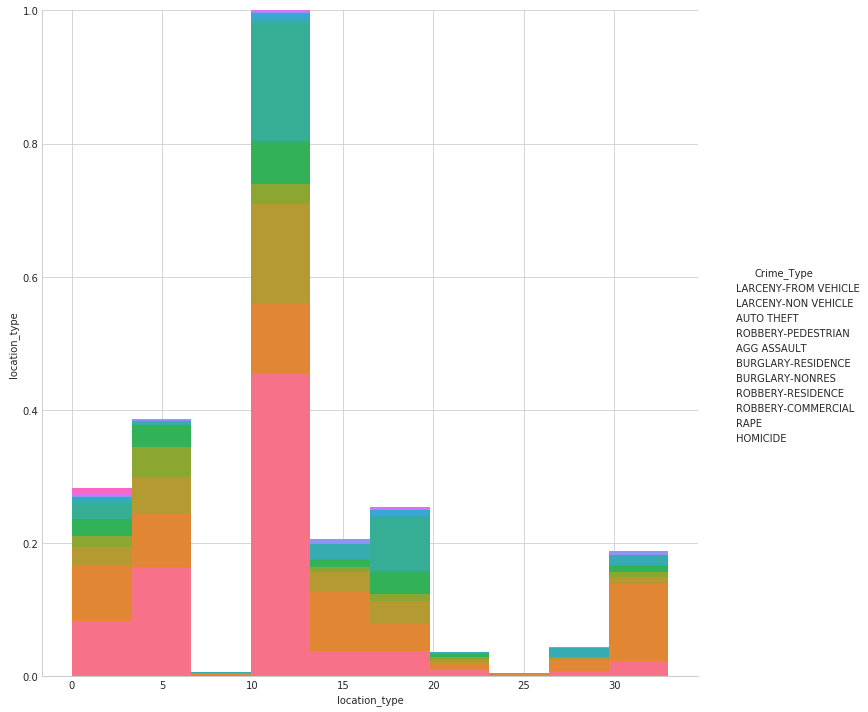

In [32]:
'''
Does any location has more/less crime type?
''' 
g = sns.pairplot(train, hue="Crime_Type", vars=['location_type'],size=10)


##### As we can see several of the locations have high prevalence of crimes and we can use it later for framing new features that can help in further analysis


# 1. Data Imputation

## 2 a. Identify inconsistencies

In [43]:
train.isnull().sum()

incident_datetime     0
incident_cord_x       0
incident_cord_y       0
num_victims          97
location_type         0
Crime_Type            0
dtype: int64

##### Number of victims had around 97 nan values.

In [46]:
train[train['location_type']==0].shape

(2745, 6)

##### Around 2745 values have missing location types

## 2 b. Imputation of NaN values in 'No_of_victims' columns

In [35]:
## checking if num_victims is null
train[train['num_victims'].isnull()].shape

(97, 6)

##### Number of victims had around 97 nan values. To impute those, we checked the distribution of the cases and found that they belonged to  Homicide exclusively. So took the mode of the feature and imputed them with those.

In [37]:
train['num_victims'].value_counts()

1.0     22698
2.0      2232
3.0       473
0.0       193
4.0       156
5.0        67
6.0        29
8.0        17
7.0        14
11.0        6
9.0         4
12.0        3
10.0        3
14.0        2
13.0        2
20.0        1
22.0        1
15.0        1
40.0        1
Name: num_victims, dtype: int64

In [44]:
# 22698/26000-- have 1 victims.. can impute with this value
train['num_victims'].fillna(1,inplace=True)

## 2c. Imputation of missing values for 'Location_types'

In [48]:
## creating a df for the missing values to refer to 
ref_train = train[train['location_type']!=0]

##### Around 1063 missing locations have the exact coordinates as some of the historical data Some have more than one location.. Imputing with most common among them

In [49]:
from collections import Counter
def impute_locations(x,y,ref):
    ## check for full coordinates
    loc_list = list(ref[(ref['incident_cord_x']==x) & (ref['incident_cord_y']==y)]['location_type'])
    try:
        return (Counter(loc_list).most_common(1)[0][0])
    except:
        return np.nan

In [50]:
## iterate to fill the empty locations
loc_empty = train[train['location_type']==0]
loc_empty['imputed_loc']= None
for index,row in loc_empty.iterrows():
    loc = impute_locations(row['incident_cord_x'],row['incident_cord_y'],ref_train)
    loc_empty.loc[index,'imputed_loc'] = loc
print ("Remaining rows to impute",loc_empty['imputed_loc'].isnull().sum())

1062

##### After finding direct matches, using rounding by 2/3 significant figures  to impute the values 

In [52]:
from collections import Counter
def impute_locations_rest(x,y,ref_x,ref_y,ref):
    ## check for full coordinates
    
    loc_list = list(ref[(ref_x==x) & (ref_y==y)]['location_type'])
    
    try:
        return (Counter(loc_list).most_common(1)[0][0])
    except:
        return np.nan

In [53]:
## iterate to fill the empty locations
ref_train['incident_cord_x_round4'] = ref_train['incident_cord_x'].map(lambda x: round(x,4))
ref_train['incident_cord_y_round4'] = ref_train['incident_cord_y'].map(lambda x: round(x,4))
ref_x = ref_train['incident_cord_x_round4'] 
ref_y = ref_train['incident_cord_y_round4'] 

loc_empty2 = loc_empty[loc_empty['imputed_loc'].isnull()==True]

for index,row in loc_empty2.iterrows():
    x =round(row['incident_cord_x'],4)
    y =round(row['incident_cord_y'],4)
    loc = impute_locations_rest(x,y,ref_x,ref_y,ref_train)
    loc_empty2.loc[index,'imputed_loc'] = loc
print ("Remaining rows to impute",loc_empty2['imputed_loc'].isnull().sum())

153

##### Rounding to 2 significant digits to get the remaining values

In [55]:
## iterate to fill the empty locations
ref_train['incident_cord_x_round2'] = ref_train['incident_cord_x'].map(lambda x: round(x,2))
ref_train['incident_cord_y_round2'] = ref_train['incident_cord_y'].map(lambda x: round(x,2))
ref_x = ref_train['incident_cord_x_round2'] 
ref_y = ref_train['incident_cord_y_round2'] 

loc_empty3 = loc_empty2[loc_empty2['imputed_loc'].isnull()==True]

for index,row in loc_empty3.iterrows():
    x =round(row['incident_cord_x'],2)
    y =round(row['incident_cord_y'],2)
    loc = impute_locations_rest(x,y,ref_x,ref_y,ref_train)
    loc_empty3.loc[index,'imputed_loc'] = loc
print ("Remaining rows to impute",loc_empty3['imputed_loc'].isnull().sum())


'''
Concatenating the imputed values
'''
frames = [loc_empty, loc_empty2, loc_empty3]
result = pd.concat(frames)
'''
Confirm that the indexes of the imputed set matches with 
that of the training data set
'''
index_imputed = set(result.index)
train_null = set(list (train[train['location_type']==0].index))
print ("Checking data consistencies-- If equal.. we are good"len(index_imputed),len(train_null))
print ("Checking data consistencies-- Should be equal to upper value",len(set.intersection(index_imputed,train_null)))

'''
Fillin the '0' location types with the imputed values
'''
for index,row in train.iterrows():
    if (row['location_type']==0):
        train.loc[index,'location_type']= result.loc[index,'imputed_loc']
        
'''
Saving the imputed data as a new train file
'''
train.to_csv('../data/imputed_train.csv')

,incident_datetime,incident_cord_x,incident_cord_y,num_victims,location_type,Crime_Type,imputed_loc
0,06-Jun-2044 01:54:00,26.622589,-38.446780,1.0,0,LARCENY-FROM VEHICLE,15
10,16-Nov-2044 19:30:00,26.618012,-38.443042,1.0,0,LARCENY-NON VEHICLE,33
35,21-Jun-2044 17:00:00,26.627220,-38.442669,1.0,0,LARCENY-FROM VEHICLE,10
36,09-Oct-2044 13:00:00,26.624050,-38.446210,1.0,0,LARCENY-FROM VEHICLE,NaN
49,13-Sep-2044 23:25:00,26.624972,-38.445804,1.0,0,AGG ASSAULT,NaN
